## Applied Example

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import statsmodels.api as sm

import sys
from importlib import reload
sys.path.append('../Dropbox/Research/data/WB')
import wb_prepare



In [9]:
## import raw data
D, L = wb_prepare.prepare_data(hhc = True, gcf = True, pop = True, emp = True, co2 = True, code = True)
print(wb_prepare.__doc__)
print(D.keys())
D['gdp'].info()


This script loads data from the World Bank for 264 countries and aggregates from 1960 to 2015, retrieved on January 24, 2017. 
Running the script returns a dictionary with the following keys and values
    - 'gdp': a pandas data frame containing real GDP (in 2010 USD) for each country and year
    - 'gcf': a pandas data frame containing gross capital formation (in 2010 USD) for each country and year
    - 'goc': a pandas data frame containing government consumption expenditures (in 2010 USD) for each country and year
    - 'hhc': a pandas data frame containing household consumption expenditures (in 2010 USD) for each country and year
    - 'exp': a pandas data frame containing exports (in 2010 USD) for each country and year
    - 'imp': a pandas data frame containing imports (in 2010 USD) for each country and year

THIS VERSION: 07/02/2017

dict_keys(['gdp', 'pop', 'hhc', 'gcf', 'co2', 'emp'])
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 1960 to 2015
Columns: 264 entr

In [38]:
start_year, end_year = 1973, 2013

## slice out data for defined time period and convert monetary data to trillion USD 
Y = D['gdp'].loc[start_year:end_year] * 1e-12
C = D['hhc'].loc[start_year:end_year] * 1e-12
I = D['gcf'].loc[start_year:end_year] * 1e-12
H = D['pop'].loc[start_year:end_year] * 1e-9  ## convert population to billion
E = D['co2'].loc[start_year:end_year] * 1e-6  ## convert emissions to Gt

In [39]:
## compute capital stock using the perpetual inventory method
delta = 0.08
K = I.copy()
T = len(I)
for country in K:
    k0 = (D['gcf'][country].loc[1992:1995]/D['gdp'][country].loc[1992:1995]).mean() / delta \
            * D['gdp'][country].loc[1992] * 1e-12
        
    K[country].iloc[0] = k0
    for t in range(T-1):
         K[country].iloc[t+1] = (1 - delta) * K[country].iloc[t] + I[country].iloc[t]

In [31]:
Y.describe()

level_1,IND,BGD,PAK,MEX,VNM,PER,COL,PHL,NPL,BRA,...,URY,UZB,VUT,VEN,VIR,WBG,WLD,YEM,ZMB,ZWE
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,19.000000,19.000000,19.000000,19.000000,0.0,19.000000,19.000000,19.000000,19.000000,19.000000
mean,1.147653,0.087065,0.143627,0.935364,0.083973,0.111558,0.235870,0.156767,0.012801,1.799498,...,0.032903,0.027955,0.000573,0.337369,NaN,0.007468,56.091991,0.023448,0.014077,0.012318
std,0.440817,0.026708,0.032313,0.134304,0.029292,0.032433,0.050260,0.039866,0.002873,0.340583,...,0.006231,0.010468,0.000102,0.063186,NaN,0.001894,9.320434,0.004608,0.005189,0.002685
min,0.604258,0.052934,0.100147,0.687208,0.043696,0.075482,0.181270,0.105213,0.008624,1.383636,...,0.025943,0.016593,0.000442,0.251580,NaN,0.003879,41.905236,0.015819,0.008274,0.007982
25%,0.796538,0.065329,0.115154,0.856051,0.059203,0.084652,0.192462,0.122700,0.010582,1.504331,...,0.028399,0.019679,0.000495,0.284262,NaN,0.006475,48.574692,0.019754,0.009697,0.010243
50%,1.027931,0.080593,0.139309,0.927362,0.079362,0.099505,0.219601,0.149721,0.012445,1.719723,...,0.030472,0.024379,0.000526,0.299230,NaN,0.007573,55.577792,0.023678,0.012450,0.011737
75%,1.443694,0.106573,0.172198,1.042103,0.106145,0.135410,0.273811,0.184385,0.014936,2.055512,...,0.036608,0.034893,0.000679,0.396777,NaN,0.008556,63.445542,0.027300,0.017598,0.015181
max,1.989650,0.138597,0.196970,1.153059,0.136658,0.176195,0.333817,0.236316,0.018058,2.409740,...,0.045897,0.049778,0.000736,0.439149,NaN,0.011009,71.058906,0.030907,0.024183,0.015913


In [20]:
## check for NaNs
print(Y.notnull().all().all(), C.notnull().all().all(), H.notnull().all().all(), I.notnull().all().all())

False False False False


#### Visualizing Data

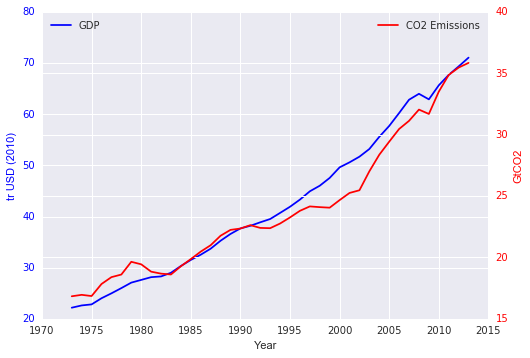

In [50]:
fig, ax1 = plt.subplots()
ax1.plot(Y['WLD'], color = 'b', label = "GDP")
ax2 = ax1.twinx()
ax2.plot(E['WLD'], color = 'r', label = 'CO2 Emissions')

ax1.set_xlabel('Year')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('tr USD (2010)', color='b')
ax1.tick_params('y', colors='b')

ax2.set_ylabel('GtCO2', color='r')
ax2.tick_params('y', colors='r')
ax1.legend(loc = 'upper left')
ax2.legend()
plt.show()


In [60]:
## convert data to np array

X = np.column_stack( ( np.log(K['WLD']), np.log(H['WLD']) ) )
X = sm.add_constant(X)
y = np.log(Y['WLD'])

res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    WLD   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     7392.
Date:                Wed, 19 Apr 2017   Prob (F-statistic):           5.87e-50
Time:                        15:39:34   Log-Likelihood:                 107.09
No. Observations:                  41   AIC:                            -208.2
Df Residuals:                      38   BIC:                            -203.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.3555      0.098     -3.627      0.0

In [63]:
y = np.log(Y['WLD']) - np.log(H['WLD'])

t = np.array(range(len(y)))
X = np.column_stack( (np.log(K['WLD']) - np.log(H['WLD']), t) )
X = sm.add_constant(X)

res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    WLD   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2092.
Date:                Wed, 19 Apr 2017   Prob (F-statistic):           1.35e-39
Time:                        15:43:14   Log-Likelihood:                 110.63
No. Observations:                  41   AIC:                            -215.3
Df Residuals:                      38   BIC:                            -210.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.4126      0.073     19.450      0.0

In [64]:
y = np.log(Y['WLD']) - np.log(H['WLD'])

t = np.array(range(len(y)))
X = np.column_stack( (np.log(K['WLD']) - np.log(H['WLD']), np.log(E['WLD']) - np.log(H['WLD']), t) )
X = sm.add_constant(X)

res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    WLD   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2617.
Date:                Wed, 19 Apr 2017   Prob (F-statistic):           4.10e-43
Time:                        15:45:07   Log-Likelihood:                 123.99
No. Observations:                  41   AIC:                            -240.0
Df Residuals:                      37   BIC:                            -233.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.3344      0.055     24.348      0.0